In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=fc6109e4e9b154d55c3b090bf71c9d4893b194af932d4b33996cccebde7125b2
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor

COLLECTING DATA

The original dataset was taken from Global Health Observatory data repository, and has five columns:

1. Country.
2. Year (2000-2015)
3. Both sexes: the adult mortality rate from both sexes 4.per 1000 population.
4. Male: the male adult mortality rate per 1000 population.
5. Female: the female adult mortality rate per 1000 population.

After adding the Continent column manually, I first read the .csv file using pandas, and name it AMR_full. I first:
1. Ignored the first row in the original dataset, because the column names are in the second row.
2. Make the columns ['Continent', 'Country', 'Year'] the indecies of the dataframe, i.e., multi-level indexing because in the original dataset the same continent and country are reapeated many times.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing pandas to read the .csv file
import pandas as pd

In [ ]:
#create a dateframe called AMR from the .csv file
AMR_full = pd.read_csv('/content/drive/MyDrive/BIG DATA/ADULT MORALITY RATE/WHOSIS_000004_new.csv', skiprows = 1,
                       #index_col = ['Continent', 'Country', 'Year']
                      )

In [ ]:
#check the first 30 rows of the dataframe
AMR_full.head(32)

,Country,Year,Both sexes,Male,Female,Continent
0,Afghanistan,2015,263,284,239,Asia
1,Afghanistan,2014,271,294,245,Asia
2,Afghanistan,2013,268,289,245,Asia
3,Afghanistan,2012,272,293,249,Asia
4,Afghanistan,2011,275,297,252,Asia
5,Afghanistan,2010,279,300,256,Asia
6,Afghanistan,2009,281,302,259,Asia
7,Afghanistan,2008,287,309,264,Asia
8,Afghanistan,2007,295,318,271,Asia
9,Afghanistan,2006,295,316,273,Asia


Now we read the second dataset as

In [ ]:
Code_GDP_df = pd.read_csv('/content/drive/MyDrive/BIG DATA/ADULT MORALITY RATE/API_NY.GDP.PCAP.CD_DS2_en_csv_v2.csv', skiprows = 4)

In [ ]:
#check the head of the dataframe
Code_GDP_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Unnamed: 62
0,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,24631.434860,24271.940421,25324.720362,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,59.777327,59.878153,58.492874,78.782758,82.208444,101.290471,...,445.893298,553.300289,603.537023,669.009051,631.744971,612.069651,569.577923,561.778746,NaN,NaN
2,Angola,AGO,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3347.844850,3529.053482,4299.012889,4598.249988,4804.616884,4709.312024,3695.793748,3308.700233,NaN,NaN
3,Albania,ALB,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4114.136545,4094.358832,4437.178068,4247.614308,4413.081697,4578.666728,3934.895394,4124.982390,NaN,NaN
4,Andorra,AND,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,43339.379875,39736.354063,41098.766942,38391.080867,40619.711298,42294.994727,36038.267604,36988.622030,NaN,NaN


From the above dataset we are interested in the (Country Code) column, and the columns 2000-2015. To extract these information, we first created two dictionary d1_country_code that contains (Country, Code) pairs, and d1_code_GDP that contains (Code, GDP per capita for the years 2015 - 2000).

In [ ]:
import numpy as np

In [ ]:
years = list(map(str, range(2015, 1999, -1)))
d1_country_code = {}
d1_code_GDP = {}
for index, row in Code_GDP_df.iterrows():
    d1_country_code[row['Country Name']] = row['Country Code']
    d1_code_GDP[row['Country Code']] = row[years]

Code1 = []
for index, row in AMR_full.iterrows():
    country = row['Country']
    if country in d1_country_code.keys():
        Code1.append(d1_country_code[country])
    else:
        Code1.append(np.nan)

Now, we add a column called Code to the dataframe AMR_full as following:

In [ ]:
AMR_full['Code'] = Code1
#check the first five rows of the dataframe where Year = 2015
AMR_full[AMR_full['Year'] == 2015].head()

,Country,Year,Both sexes,Male,Female,Continent,Code
0,Afghanistan,2015,263,284,239,Asia,AFG
16,Albania,2015,74,98,51,Europe,ALB
32,Algeria,2015,109,134,83,Africa,DZA
48,Angola,2015,335,362,308,Africa,AGO
64,Antigua and Barbuda,2015,130,154,108,North America,ATG


We can check the NaN values in the contructed dataframe using the heatmap plot from seaborn.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<Axes: >

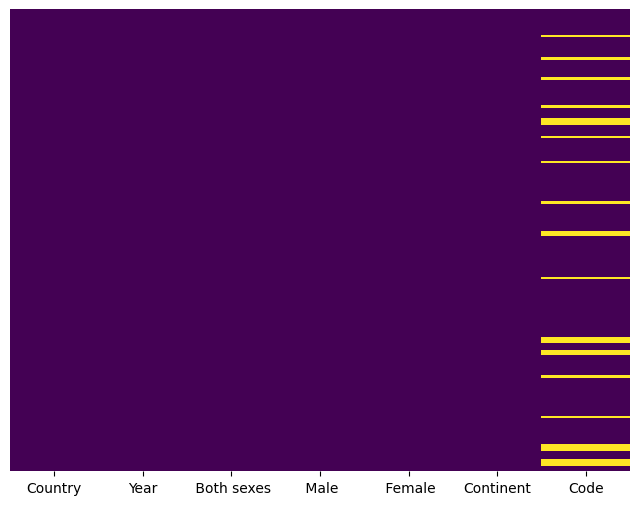

In [ ]:
plt.figure(figsize = (8,6))
sns.heatmap(AMR_full.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

We can see that there are some missing data in the Code column. This is due the mismatch in country names in the two datasets. So, now the above dataframe is saved, and then the missing data will be filled manually from this website.

In [ ]:
AMR_full.to_csv('/content/drive/MyDrive/BIG DATA/ADULT MORALITY RATE/AMR_full_Code_missing.csv')

After filling the missing data, we overwrite the dataframe AMR_full with the new completed dataset as follows:

<Axes: >

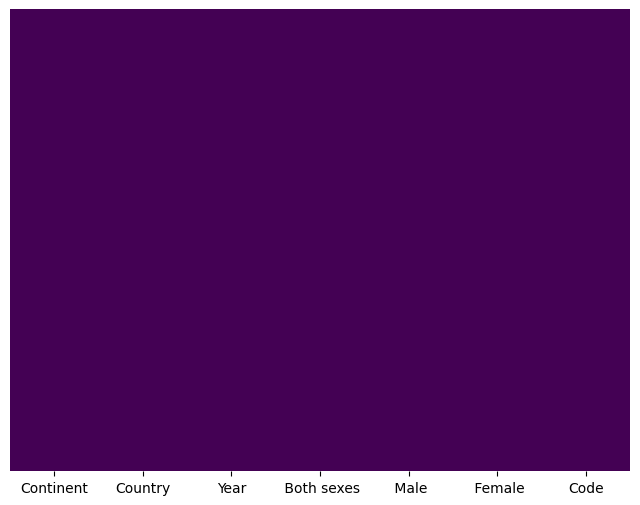

In [ ]:
AMR_full = pd.read_csv('/content/drive/MyDrive/BIG DATA/ADULT MORALITY RATE/AMR_full_Code_Filled_Manually.csv', encoding = 'latin-1')
plt.figure(figsize = (8,6))
sns.heatmap(AMR_full.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

We see that there is no missing data in our dataframe. We proceed to fill the GDP per capita column. For this, we will use the Code column because it is the same in both datasets, not like the names)

In [ ]:
GDP1 = []

for index, row in AMR_full.iterrows():
    code = row['Code']
    if (code != np.nan):
        if ((index % 16) == 15):
            if code in d1_code_GDP.keys():
                TheCode = d1_code_GDP[code]
                GDP1.extend(TheCode)
            else:
                GDP1.extend(np.ones(16)*np.nan)

We add a new column called (GDP per capita (USD)) as follows:

In [ ]:
AMR_full['GDP per capita (USD)'] = GDP1
AMR_full[(AMR_full['Year'] == 2015) | (AMR_full['Year'] == 2000)].head(30)

,Continent,Country,Year,Both sexes,Male,Female,Code,GDP per capita (USD)
0,Asia,Afghanistan,2015,263,284,239,AFG,569.577923
15,Asia,Afghanistan,2000,321,345,296,AFG,NaN
16,Europe,Albania,2015,74,98,51,ALB,3934.895394
31,Europe,Albania,2000,110,146,70,ALB,1175.788981
32,Africa,Algeria,2015,109,134,83,DZA,4160.220067
47,Africa,Algeria,2000,145,163,126,DZA,1757.017797
48,Africa,Angola,2015,335,362,308,AGO,3695.793748
63,Africa,Angola,2000,408,437,379,AGO,555.296942
64,North America,Antigua and Barbuda,2015,130,154,108,ATG,13659.147914
79,North America,Antigua and Barbuda,2000,156,181,133,ATG,9932.029681


<Axes: >

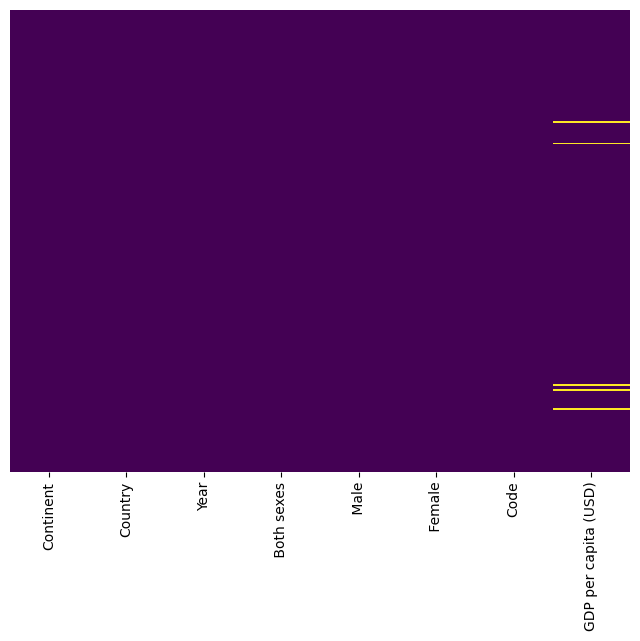

In [ ]:
plt.figure(figsize = (8,6))
sns.heatmap(AMR_full.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

We see that there are some missing data in the new added column GDP per capita (USD). We can print countries that have missing data as follows:

In [ ]:
def find_country(d1, code):
    for key, value in d1.items():
        #print(key)
        #print(value)
        if value == code:
            return key

missing_codes = set(AMR_full[AMR_full['GDP per capita (USD)'].isnull()]['Code'])
#missing_years = (AMR_full_copy_new[AMR_full_copy_new['GDP per capita (USD)'].isnull()]['Year'])
#missing_years
for code in missing_codes:
    print('*** Country: ', find_country(d1_country_code, code), '| Code:', code)
    print()
    print(AMR_full[AMR_full['Code'] == code][['Year', 'GDP per capita (USD)']])
    print('\n*** The number of missing data is: ',
          (AMR_full[AMR_full['Code'] == code]['GDP per capita (USD)'].isnull().value_counts()[True]))
    print('\n===========================================================================================================')

*** Country:  Iraq | Code: IRQ

      Year  GDP per capita (USD)
1232  2015           4974.026930
1233  2014           6703.074737
1234  2013           6925.224046
1235  2012           6651.122420
1236  2011           5854.614497
1237  2010           4502.749048
1238  2009           3735.144836
1239  2008           4521.032470
1240  2007           3129.224922
1241  2006           2351.812429
1242  2005           1849.603911
1243  2004           1391.816923
1244  2003                   NaN
1245  2002                   NaN
1246  2001                   NaN
1247  2000                   NaN

*** The number of missing data is:  4

*** Country:  Syrian Arab Republic | Code: SYR

      Year  GDP per capita (USD)
2528  2015                   NaN
2529  2014                   NaN
2530  2013                   NaN
2531  2012                   NaN
2532  2011                   NaN
2533  2010                   NaN
2534  2009                   NaN
2535  2008                   NaN
2536  2007           2

Next we will deal with addressing these missing data.

CLEANING DATA

From the last cell excution, we notice that the only country has no available data in the GDP per capita (USD) column is North Korea officially know as the Democtratic People's Repulic of Korea. We will have to find these information online. For all other countries we will replace the missing data with the average of the available data.

In [ ]:
for code in missing_codes:
    if code != 'PRK':#To exlude North Korea since it has no numeric values
        avg = (AMR_full[AMR_full['Code'] == code]['GDP per capita (USD)']).mean()
        AMR_full.loc[AMR_full['Code'] == code, 'GDP per capita (USD)'] = AMR_full.loc[AMR_full['Code'] == code, 'GDP per capita (USD)'].fillna(avg)

In [ ]:
for code in missing_codes:
    print('*** Country: ', find_country(d1_country_code, code), '| Code:', code)
    print()
    print(AMR_full[AMR_full['Code'] == code][['Year', 'GDP per capita (USD)']])
    #print('\n*** The number of missing data is: ',
      #    (AMR_full[AMR_full['Code'] == code]['GDP per capita (USD)'].isnull().value_counts()[True]))
    print('\n===========================================================================================================')

*** Country:  Iraq | Code: IRQ

      Year  GDP per capita (USD)
1232  2015           4974.026930
1233  2014           6703.074737
1234  2013           6925.224046
1235  2012           6651.122420
1236  2011           5854.614497
1237  2010           4502.749048
1238  2009           3735.144836
1239  2008           4521.032470
1240  2007           3129.224922
1241  2006           2351.812429
1242  2005           1849.603911
1243  2004           1391.816923
1244  2003           4382.453931
1245  2002           4382.453931
1246  2001           4382.453931
1247  2000           4382.453931

*** Country:  Syrian Arab Republic | Code: SYR

      Year  GDP per capita (USD)
2528  2015           1469.880914
2529  2014           1469.880914
2530  2013           1469.880914
2531  2012           1469.880914
2532  2011           1469.880914
2533  2010           1469.880914
2534  2009           1469.880914
2535  2008           1469.880914
2536  2007           2058.035209
2537  2006           1762.24

Now, that all countries except North Korea have full GDP per capita information. From this website, GDP per capita in North Korea for the avialble years are



So, we see that some years are still missing. We will these missing data using the average of the avialable years. We define a list contains the GDP per capita (USD) for 2015 down to 2000 as follows:

In [ ]:
GDP_PRK = [1700, np.nan, np.nan, np.nan, 1800, np.nan, 1800, 1800, 1700, 1800, 1700, 1700, 1300, 1000, np.nan, 1000]

In [ ]:
AMR_full.loc[AMR_full['Code'] == 'PRK', 'GDP per capita (USD)'] = GDP_PRK
GDP_PRK_avg = AMR_full.loc[AMR_full['Code'] == 'PRK', 'GDP per capita (USD)'].mean()
AMR_full.loc[AMR_full['Code'] == 'PRK', 'GDP per capita (USD)'] = AMR_full.loc[AMR_full['Code'] == 'PRK', 'GDP per capita (USD)'].fillna(GDP_PRK_avg)

for code in missing_codes:
    print('*** Country: ', find_country(d1_country_code, code), '| Code:', code)
    print()
    print(AMR_full[AMR_full['Code'] == code][['Year', 'GDP per capita (USD)']])
    #print('\n*** The number of missing data is: ',
      #    (AMR_full[AMR_full['Code'] == code]['GDP per capita (USD)'].isnull().value_counts()[True]))
    print('\n===========================================================================================================')

*** Country:  Iraq | Code: IRQ

      Year  GDP per capita (USD)
1232  2015           4974.026930
1233  2014           6703.074737
1234  2013           6925.224046
1235  2012           6651.122420
1236  2011           5854.614497
1237  2010           4502.749048
1238  2009           3735.144836
1239  2008           4521.032470
1240  2007           3129.224922
1241  2006           2351.812429
1242  2005           1849.603911
1243  2004           1391.816923
1244  2003           4382.453931
1245  2002           4382.453931
1246  2001           4382.453931
1247  2000           4382.453931

*** Country:  Syrian Arab Republic | Code: SYR

      Year  GDP per capita (USD)
2528  2015           1469.880914
2529  2014           1469.880914
2530  2013           1469.880914
2531  2012           1469.880914
2532  2011           1469.880914
2533  2010           1469.880914
2534  2009           1469.880914
2535  2008           1469.880914
2536  2007           2058.035209
2537  2006           1762.24

<Axes: >

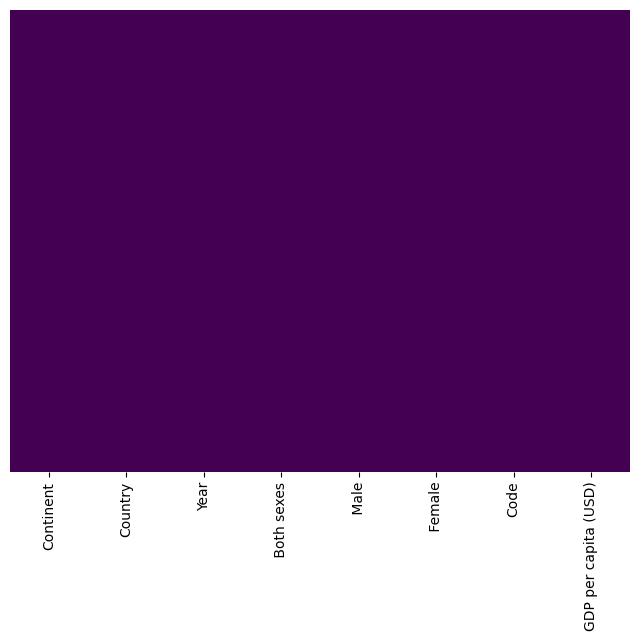

In [ ]:
plt.figure(figsize = (8,6))
sns.heatmap(AMR_full.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

We see that now our dataset is clean, i.e., there is no missing data. Next we will proceed to do some exploratory data analysis (EDA) on the data.

Exploratory data analysis (EDA)

In [ ]:
AMR_full.head()

,Continent,Country,Year,Both sexes,Male,Female,Code,GDP per capita (USD)
0,Asia,Afghanistan,2015,263,284,239,AFG,569.577923
1,Asia,Afghanistan,2014,271,294,245,AFG,612.069651
2,Asia,Afghanistan,2013,268,289,245,AFG,631.744971
3,Asia,Afghanistan,2012,272,293,249,AFG,669.009051
4,Asia,Afghanistan,2011,275,297,252,AFG,603.537023


First, we compare the average adult mortality rate for each continent between 2000 and 2015, for each of the types (both sexes, male, and female).

In [ ]:
AMR_full_groupby_continent = AMR_full.groupby('Continent').mean()
AMR_full_groupby_continent

<ipython-input-27-92f489e595b0>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  AMR_full_groupby_continent = AMR_full.groupby('Continent').mean()


,Year,Both sexes,Male,Female,GDP per capita (USD)
Continent,,,,,
Africa,2007.5,322.113426,346.806713,297.987269,2013.935417
Asia,2007.5,157.840426,193.273936,120.613032,9402.654840
Europe,2007.5,112.133013,153.296474,70.197115,25699.180331
North America,2007.5,154.462500,191.875000,117.268750,10332.154813
Oceania,2007.5,168.725000,197.087500,139.600000,9275.686196
South America,2007.5,159.461538,200.014423,117.750000,6465.857835


In [ ]:
#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
AMR_full_groupby_continent.columns

Index(['Year', ' Both sexes', ' Male', ' Female', 'GDP per capita (USD)'], dtype='object')

Note: We note that the some column names are preceded by a blank space before each name. We need to consider this when calling columns.

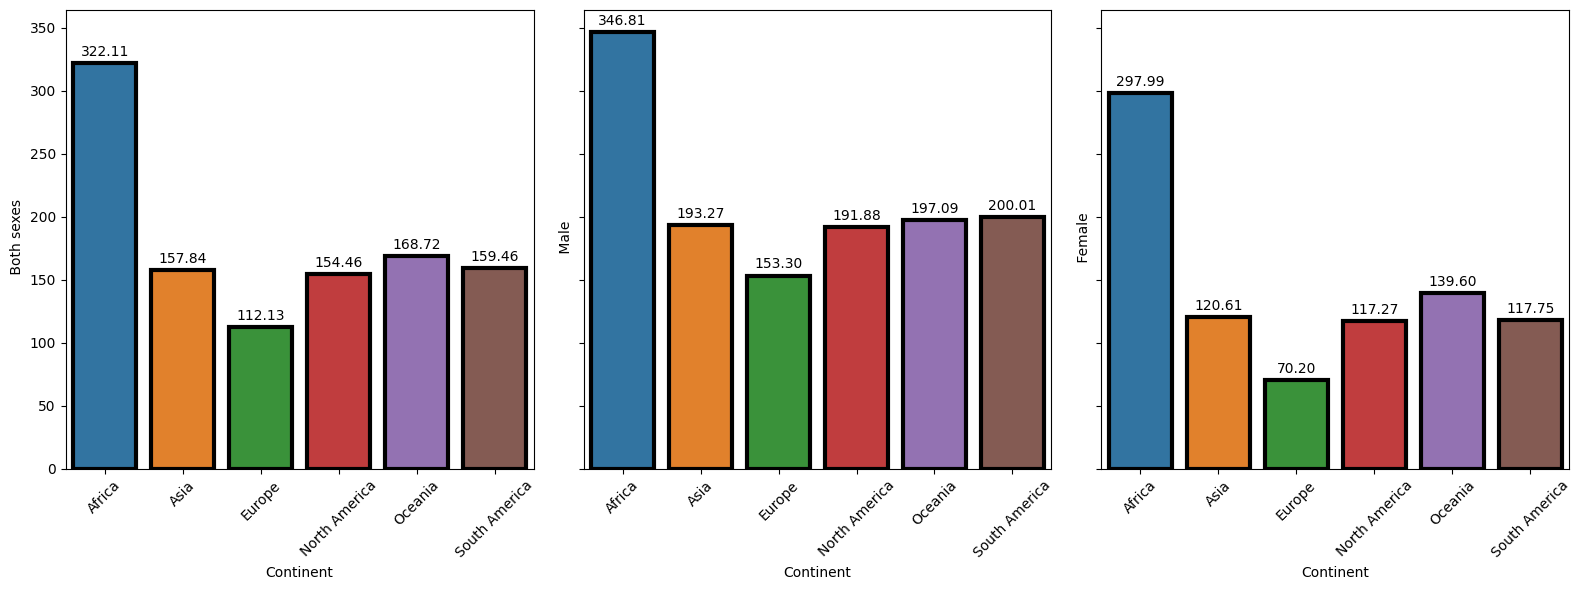

In [ ]:
fig, ax = plt.subplots(1, 3, sharey = True, figsize = (16, 6))

#rotate the lables in the x-axis by 45 degrees
for i in range(3):
    ax[i].xaxis.set_tick_params(rotation=45)


g0 = sns.barplot(x = 'Continent', y = ' Both sexes', data = AMR_full_groupby_continent.reset_index(),
            edgecolor = ['k', 'k', 'k', 'k', 'k', 'k'], linewidth = 3, ax = ax[0])
for p in g0.patches:
        g0.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', xytext=(0, 8), textcoords='offset points')

g1 = sns.barplot(x = 'Continent', y = ' Male', data = AMR_full_groupby_continent.reset_index(),
            edgecolor = ['k', 'k', 'k', 'k', 'k', 'k'], linewidth = 3, ax = ax[1])
for p in g1.patches:
        g1.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', xytext=(0, 8), textcoords='offset points')

g2 = sns.barplot(x = 'Continent', y = ' Female', data = AMR_full_groupby_continent.reset_index(),
            edgecolor = ['k', 'k', 'k', 'k', 'k', 'k'], linewidth = 3, ax = ax[2])
for p in g2.patches:
        g2.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', xytext=(0, 8), textcoords='offset points')

plt.tight_layout()

We can see immediately that Africa has the highest average adult mortality rate between the years 2000 and 2015. On the other hand, Europe has the lowset average adult mortality rate. Also, we see that male average mortality rate is higher than female average adult mortality rate in all continents.

<Axes: xlabel='Continent', ylabel=' Both sexes'>

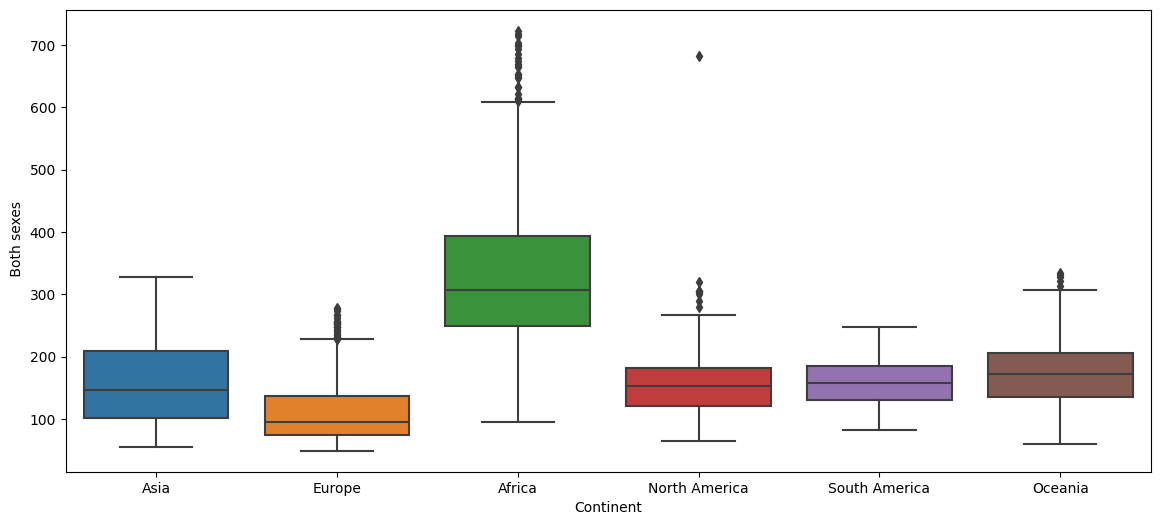

In [ ]:
plt.figure(figsize = (14, 6))
sns.boxplot(x = 'Continent', y = ' Both sexes', data = AMR_full)

In [ ]:
AMR_full_groupby_continent

,Year,Both sexes,Male,Female,GDP per capita (USD)
Continent,,,,,
Africa,2007.5,322.113426,346.806713,297.987269,2013.935417
Asia,2007.5,157.840426,193.273936,120.613032,9402.654840
Europe,2007.5,112.133013,153.296474,70.197115,25699.180331
North America,2007.5,154.462500,191.875000,117.268750,10332.154813
Oceania,2007.5,168.725000,197.087500,139.600000,9275.686196
South America,2007.5,159.461538,200.014423,117.750000,6465.857835


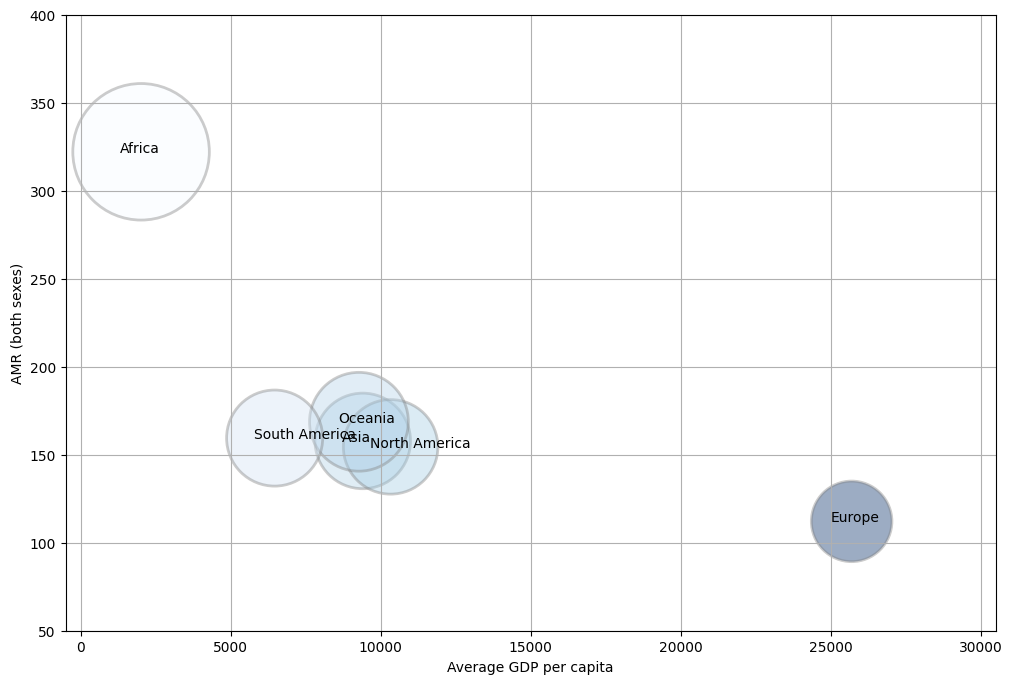

In [ ]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.scatter(x = 'GDP per capita (USD)', y = ' Both sexes', c = AMR_full_groupby_continent['GDP per capita (USD)'],
           data = AMR_full_groupby_continent, s = AMR_full_groupby_continent[' Both sexes']*30,
            cmap = 'Blues', edgecolors="grey", linewidth=2, alpha = 0.4)
for index, row in AMR_full_groupby_continent.iterrows():
    #ax.text(row[3], row[0], index)
    ax.annotate(index, xy = (row[4], row[1]), xytext = (-15, 0), textcoords='offset points')
#ax.text(2500, 250, 'Hello')
plt.xlabel('Average GDP per capita')
plt.ylabel('AMR (both sexes)')
plt.ylim(50, 400)
plt.xlim(-500, 30500)
plt.grid()

We note Africa has the lowest average GDP per capita in 2015, and the highest average adult mortality rate. On the other hand, Europe, has the hihest average GDP per capita in 2015, and the lowest average adult mortality rate. It seems that, generally speaking, there is a negative relationship between GDP per capita and average adult mortality rate.

Text(0, 0.5, 'Number of Countries/Continent')

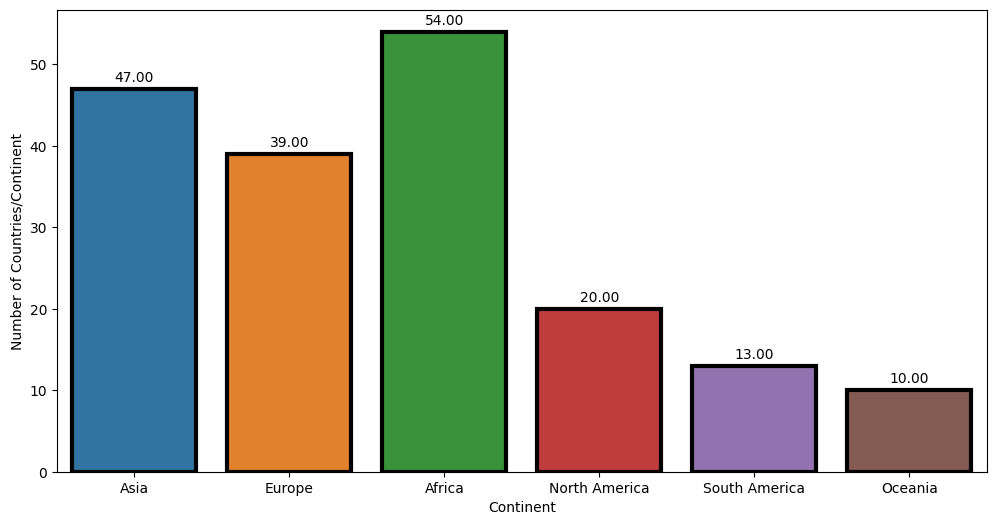

In [ ]:
plt.figure(figsize = (12, 6))
g = sns.countplot(x = 'Continent', data = AMR_full[AMR_full['Year'] == 2015], edgecolor = ['k', 'k', 'k', 'k', 'k', 'k'], linewidth = 3)
for p in g.patches:
    g.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
               ha='center', va='center', xytext=(0, 8), textcoords='offset points')
plt.ylabel('Number of Countries/Continent')

In [ ]:
continents = list(AMR_full['Continent'].unique())
continents

['Asia', 'Europe', 'Africa', 'North America', 'South America', 'Oceania']

In [ ]:
AMR_GDP_2015 = AMR_full[AMR_full['Year'] == 2015]
AMR_GDP_2015.head()

,Continent,Country,Year,Both sexes,Male,Female,Code,GDP per capita (USD)
0,Asia,Afghanistan,2015,263,284,239,AFG,569.577923
16,Europe,Albania,2015,74,98,51,ALB,3934.895394
32,Africa,Algeria,2015,109,134,83,DZA,4160.220067
48,Africa,Angola,2015,335,362,308,AGO,3695.793748
64,North America,Antigua and Barbuda,2015,130,154,108,ATG,13659.147914


<ipython-input-37-2f7893ca5c29>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(AMR_GDP_2015[AMR_GDP_2015['Continent'] == continents[count]]['GDP per capita (USD)'],


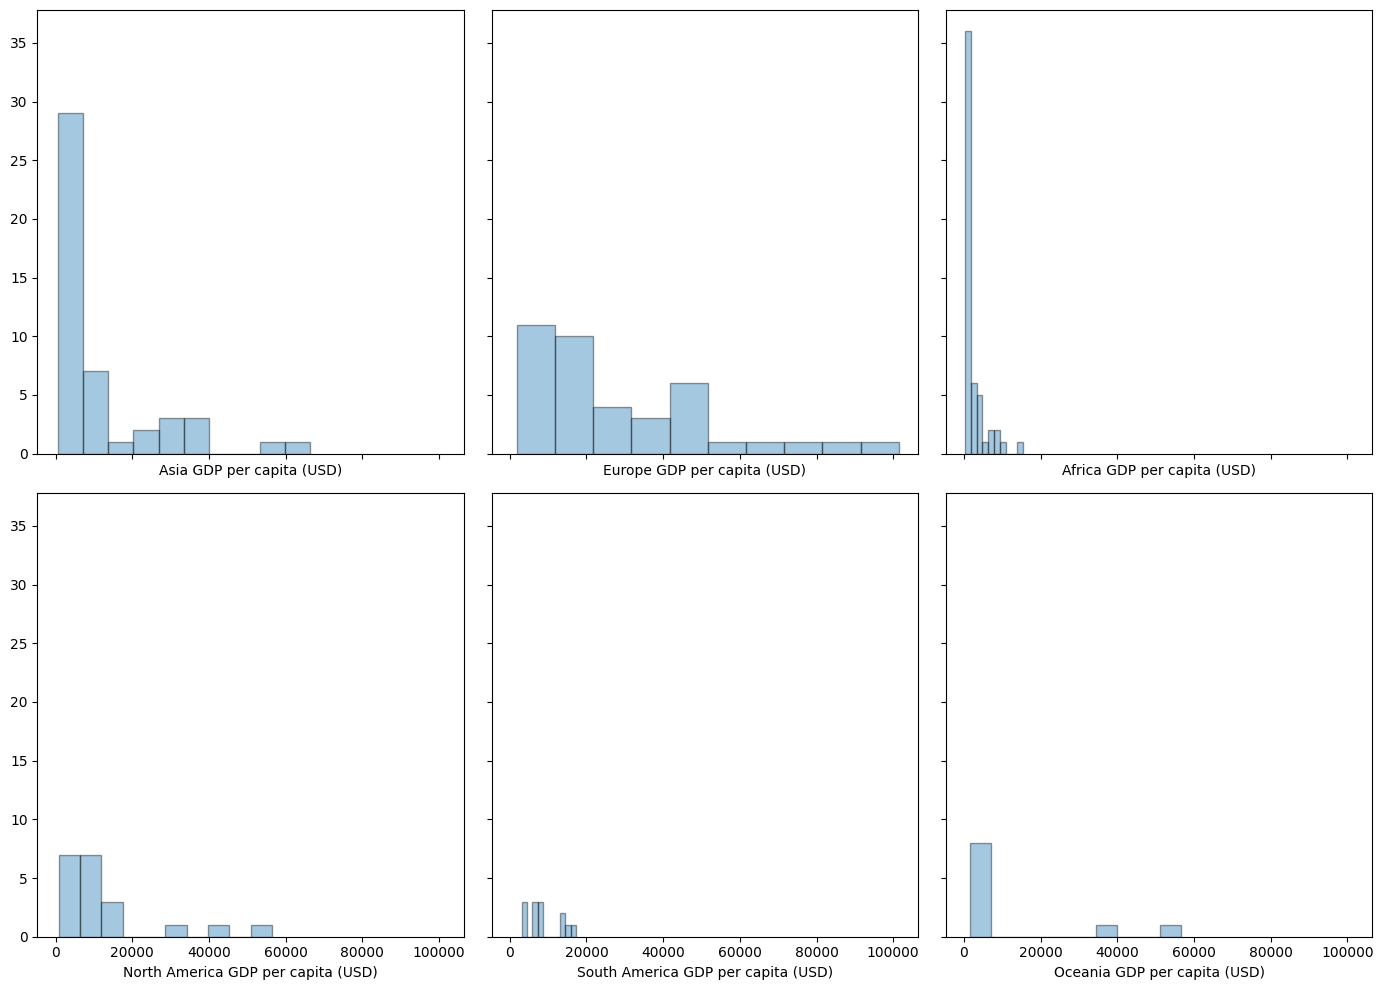

In [ ]:
fig, ax = plt.subplots(2, 3, sharey = True, sharex = True, figsize = (14, 10))
count = 0
for i in range(2):
    for j in range(3):
        sns.distplot(AMR_GDP_2015[AMR_GDP_2015['Continent'] == continents[count]]['GDP per capita (USD)'],
                     ax = ax[i,j], kde = False, hist_kws = dict(edgecolor = 'k'), bins = 10)
        ax[i, j].set_xlabel(continents[count]+' GDP per capita (USD)')
        count += 1
plt.tight_layout()

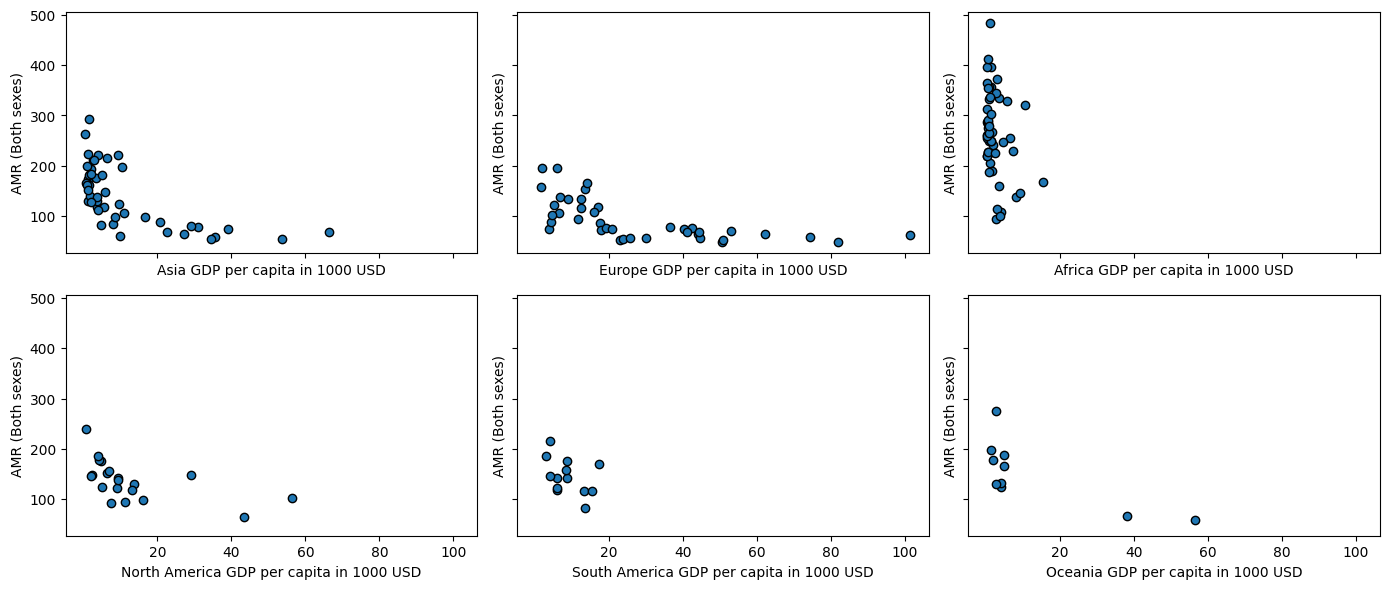

In [ ]:
fig, ax = plt.subplots(2, 3, figsize = (14, 6), sharey = True, sharex = True)
plt.setp(ax, xticks=[20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000], xticklabels=[20, 40, 60, 80, 100, 120, 140, 160])
count = 0
for i in range(2):
    for j in range(3):
        ax[i, j].scatter(x = 'GDP per capita (USD)', y = ' Both sexes',
                         data = AMR_GDP_2015[AMR_GDP_2015['Continent'] == continents[count]], edgecolor = 'k')
        ax[i, j].set_xlabel(continents[count]+' GDP per capita in 1000 USD')
        ax[i, j].set_ylabel('AMR (Both sexes)')
        count += 1
plt.tight_layout()

We saw that South America behaved oddly when we compared the average adult mortality rate and the average GDP per capita, namely, it had an average GDP per capita greater than each of Asia, Oceania, and North America, yet it had almost the same average adult mortality rate. From the scatter plots above we see that Sounth America 13 countries in the dataset, all of which but one is above 20,000 USD, actually is way above 20,000 USD yet it has a similar AMR to other South America countries (what is this country?). The variance in the distribution explains the high average GDP per capita, while the clustering of all other countries below 20,000 USD explains the relatively high average adult mortality rate.

Something interesting we note from the scatter plots of all continents is that the AMR declines and stays low after the GDP per capita threshold of 20,000 USD. All African countries have a GDP per capita less that 20,000 USD, but they have very different AMR. This suggests that below the threshold 20,000 USD, another factor plays a role in the rate of AMR.

(0.0, 20000.0)

<Figure size 1200x600 with 0 Axes>

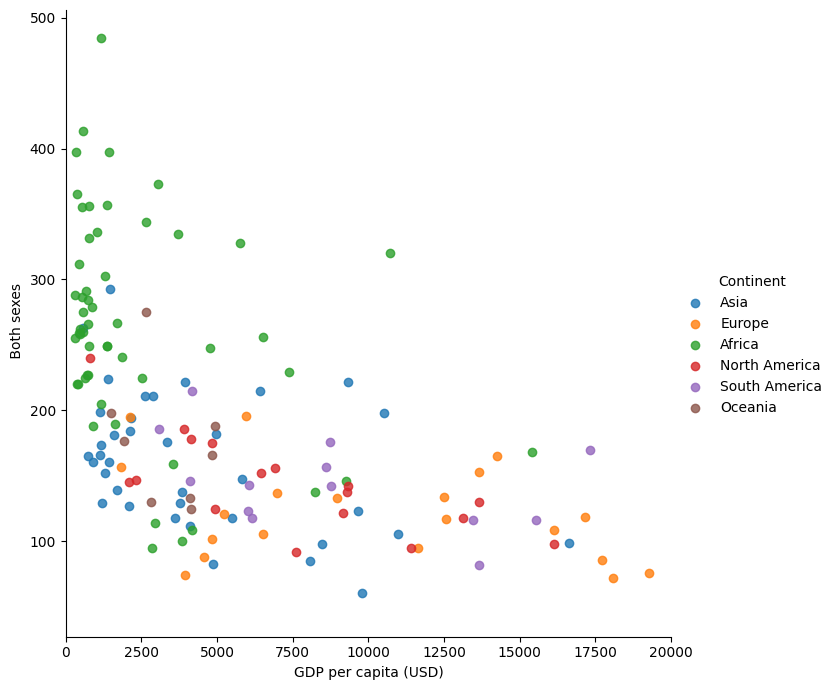

In [ ]:
plt.figure(figsize=(12, 6))
sns.lmplot(x='GDP per capita (USD)', y=' Both sexes', data=AMR_GDP_2015, hue='Continent', fit_reg=False, height=7)
plt.xlim([0, 20000])

In [ ]:
import cufflinks as cf

In [ ]:
cf.go_offline()

In [ ]:
from plotly.offline import plot, iplot, init_notebook_mode, download_plotlyjs
import plotly.graph_objs as go

In [ ]:
init_notebook_mode(connected = True)

In [ ]:
data = []
for cont in continents:
    trace = go.Scatter(
        x = AMR_GDP_2015[AMR_GDP_2015['Continent'] == cont]['GDP per capita (USD)'],
        y = AMR_GDP_2015[AMR_GDP_2015['Continent'] == cont][' Both sexes'],
        mode = 'markers',
        name = cont)
    data.append(trace)

In [ ]:
iplot(data)

In [ ]:
AMR_GDP_2015.head()

,Continent,Country,Year,Both sexes,Male,Female,Code,GDP per capita (USD)
0,Asia,Afghanistan,2015,263,284,239,AFG,569.577923
16,Europe,Albania,2015,74,98,51,ALB,3934.895394
32,Africa,Algeria,2015,109,134,83,DZA,4160.220067
48,Africa,Angola,2015,335,362,308,AGO,3695.793748
64,North America,Antigua and Barbuda,2015,130,154,108,ATG,13659.147914


Now we will see if the average adult mortality rate declines with the passing of time for each country. To do this, we need first group the countries of the same continent by each year, and then find the average adult mortality rate. This easy using groupby method, and thus we need first to reset the index such that the continent and year indices are columns.

<ipython-input-49-544004d2b483>:6: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



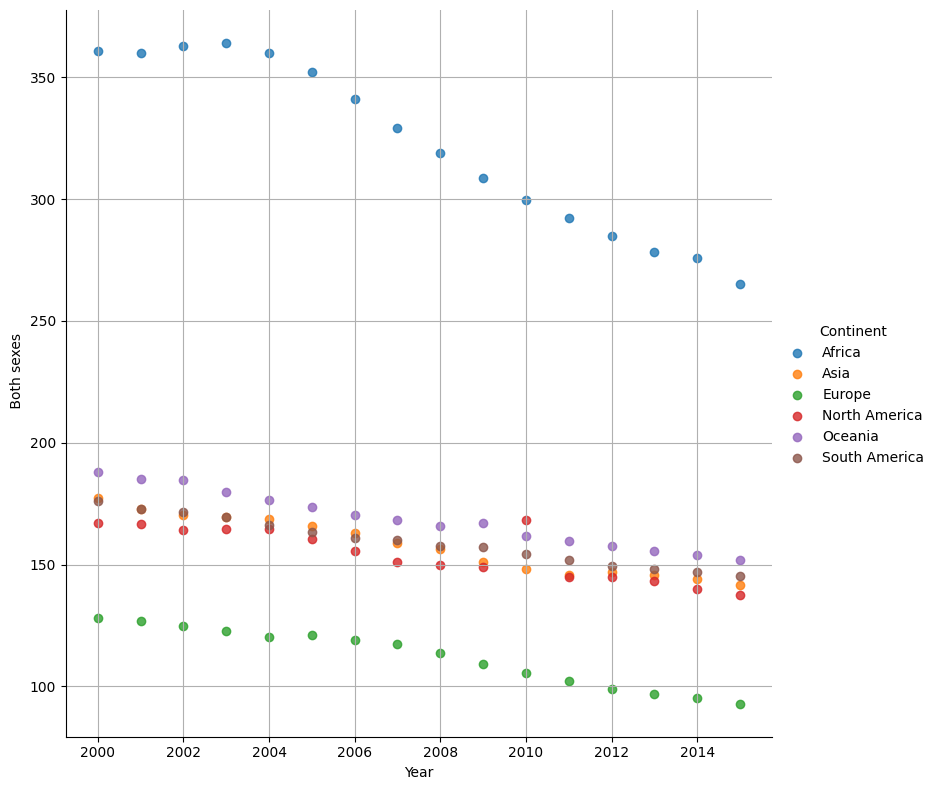

In [ ]:
# sns.lmplot(x = 'Year', y = ' Both sexes', data = grouped_cont_year.reset_index(level = ['Year', 'Continent']),
#            fit_reg = False, hue = 'Continent', size = 8)
# plt.grid()

sns.lmplot(x='Year', y=' Both sexes',
           data=AMR_full.groupby(['Continent', 'Year']).mean().reset_index(level=['Continent', 'Year']),
           fit_reg=False, hue='Continent', height=8)
plt.grid()

In [ ]:
grouped_cont_year_rstIndx = AMR_full.groupby(['Continent', 'Year']).mean().reset_index(level = ['Continent', 'Year'])

<ipython-input-50-fd78dd57cd52>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [ ]:
data = []
for cont in continents:
    trace = go.Scatter(
        x = grouped_cont_year_rstIndx[grouped_cont_year_rstIndx['Continent'] == cont]['Year'],
        y = grouped_cont_year_rstIndx[grouped_cont_year_rstIndx['Continent'] == cont][' Both sexes'],
        mode = 'markers',
        name = cont)
    data.append(trace)
iplot(data)

We can see from the scatter plots above that, although African countries still have the highest average mortality rate, it (the average mortality rate) declined significantly over the 15 years from 2000 to 2015. In numbers, it dropped from more that 360 per 1000 population, to 265 per 1000 population. This is a drop of 100 person on average per 1000 population, compared to other continents where the drop is not that significant.

Something intersting to note in the figure is North America, where we see that the average adult mortality rate increased at 2010. This is the year when Haiti was struch by an Earthquake of magnitude 7
, and caused the death of more than 160,000 people. Otherwise, the trend in all continents is the same; declining.

Next, I will draw a choropleth map using plotly that shows the countries and the average AMR on the map.

In [ ]:
import numpy as np

In [ ]:
data = dict(type = 'choropleth',
            locations = AMR_GDP_2015['Code'],
            z = AMR_GDP_2015[' Both sexes'],
            text = AMR_GDP_2015['Country'],
            colorscale = 'Viridis',
            reversescale = True,
            colorbar = {'title': 'AMR per 1000'})

In [ ]:
layout = dict(title = 'Chrorpleth Map: Adult Mortality Rate',
             geo = dict(showframe = False, projection = {'type': 'Mercator'}))

In [ ]:
choromap3 = go.Figure(data = [data], layout = layout)

In [ ]:
iplot(choromap3)

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.6 MB/s eta 0:00:00


In [ ]:
# Data preprocessing
import numpy as np
import pandas as pd


# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Warning control
import warnings
warnings.filterwarnings('ignore')

# Machine learning models
import sklearn
# Decision Tree model
from sklearn import tree
# Random Forest and Gradient Boosting models
from sklearn import ensemble
# Quality Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Sample split
from sklearn.model_selection import train_test_split
# A Skew and a Student’s t continuous random variable
from scipy import stats
# Linear Regression model
import statsmodels.api as sm

# Framework for fitting model hyperparameters
import optuna

Distribution of Life Expectancy Data

In [ ]:
# odf - original data frame
odf = pd.read_csv('/content/drive/MyDrive/BIG DATA/ADULT MORALITY RATE/Life Expectancy Data.csv')
odf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [ ]:
# The Status column includes two object type variables, so it was replaced with
# an integer variable.
odf["Status"] = pd.factorize(odf["Status"])[0]

<Axes: xlabel='under-five deaths ', ylabel='Count'>

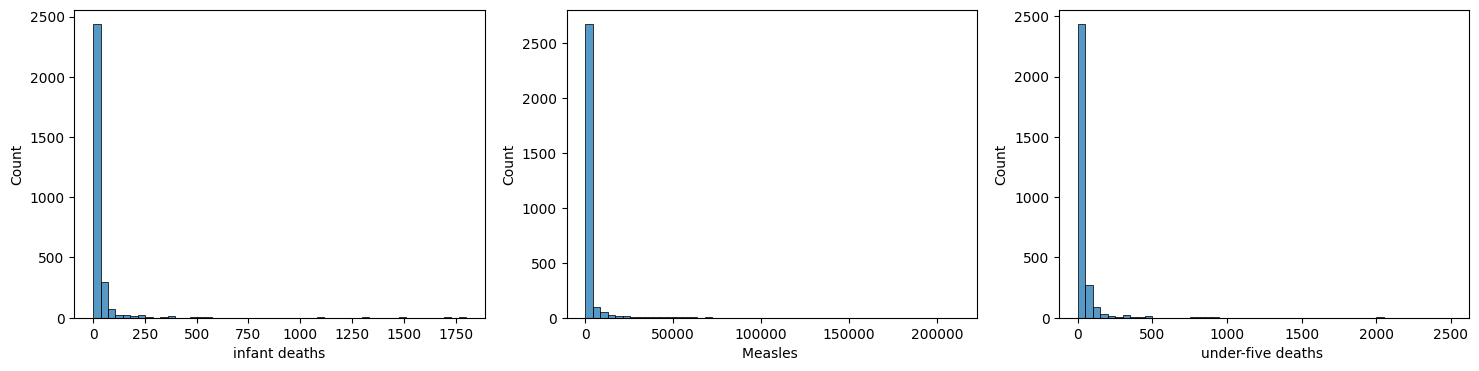

In [ ]:
# Values greater than 1000 are visible. Which, based on the description of the factors,
# cannot be.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4), sharey=False)
sns.histplot(data=odf, x='infant deaths', ax=ax1, bins = 50)
sns.histplot(data=odf, x='Measles ', ax=ax2, bins = 50)
sns.histplot(data=odf, x='under-five deaths ', ax=ax3, bins = 50)

In [ ]:
# Let's replace values greater than 1000 with an object of type NaN.
# And we add 3 columns with the binary value of the variable,
# where zero means the value is missing, and one means its presence

controversial_factors = ['infant deaths','Measles ','under-five deaths ']

for coll in controversial_factors:
    odf[coll + '_Nan'] = 1
    for i in range(len(odf)):
        if odf.loc[i, coll] > 1000:
            odf.loc[i, coll] = None
    odf[coll + '_Nan'][odf[coll].isna()] = 0

In [ ]:
odf.isna().mean() * 100

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.340368
Adult Mortality                     0.340368
infant deaths                       0.442478
Alcohol                             6.603131
percentage expenditure              0.000000
Hepatitis B                        18.822328
Measles                            17.869299
 BMI                                1.157250
under-five deaths                   0.544588
Polio                               0.646698
Total expenditure                   7.692308
Diphtheria                          0.646698
 HIV/AIDS                           0.000000
GDP                                15.248468
Population                         22.191967
 thinness  1-19 years               1.157250
 thinness 5-9 years                 1.157250
Income composition of resources     5.684139
Schooling                           5.547992
infant dea

In [ ]:
# We will fill in the gaps with the median for each country separately.
# Since the value of the characteristic can vary significantly between different countries.
# Let us indicate the factors in which gaps will not be considered.
drop_coll = []
for c in range(len(odf.columns)):
    if 0<=c<=3 or 22<=c<=24:
        drop_coll.append(odf.columns[c])
drop_coll

['Country',
 'Year',
 'Status',
 'Life expectancy ',
 'infant deaths_Nan',
 'Measles _Nan',
 'under-five deaths _Nan']

In [ ]:
# We also remove countries for which only one row is allocated in the data set.
# Determine how many rows refer to other countries
# Determine the number of factors that are missing for at least one country
# Determine the number of countries that have at least one missing factor

drop_country_list = set()
drop_coll_list = pd.DataFrame()
number_of_country_rows = set()

# Define a list of unique countries
country_values = odf['Country'].unique()
count = 0

for country in country_values:

    # We form a slice of data corresponding to a unique country
    rows = pd.DataFrame()
    rows = odf[odf['Country'] == country]
    count_rows = len(rows)
    idx = rows.index.tolist()
    number_of_country_rows.add(count_rows)

    # Looking for countries that match more than 1 row
    if count_rows > 1:
        for coll in odf.columns:
            if coll not in drop_coll:
                if odf.loc[idx[0]: idx[-1], coll].nunique() < 4:
                    # Create a data frame for countries with missing factors
                    drop_coll_list.loc[count, 'Country'] = country
                    drop_coll_list.loc[count, 'Factor'] = coll
                    count += 1
    else:
        drop_country_list.add(country)

print('The number of countries in the dataset that have only 1 row is : {}.'.format(len(drop_country_list)))
print('All other {0} countries have {1} rows.'.format(len(country_values) - len(drop_country_list), list(number_of_country_rows)[0]))
print('The number of factors that have 13 or more gaps out of 16 values for at least one of the countries: {}'.format(drop_coll_list['Factor'].nunique()))
print('Number of countries that have 13 or more missing values for at least one factor: {}'.format(drop_coll_list['Country'].nunique()))

The number of countries in the dataset that have only 1 row is : 10.
All other 183 countries have 16 rows.
The number of factors that have 13 or more gaps out of 16 values for at least one of the countries: 17
Number of countries that have 13 or more missing values for at least one factor: 161


In [ ]:
# Countries and their missing factors
drop_coll_list.head(20)

,Country,Factor
0,Afghanistan,Alcohol
1,Afghanistan,HIV/AIDS
2,Albania,infant deaths
3,Albania,under-five deaths
4,Albania,Polio
5,Albania,Diphtheria
6,Albania,HIV/AIDS
7,Algeria,infant deaths
8,Algeria,HIV/AIDS
9,Antigua and Barbuda,infant deaths


In [ ]:
# Each country has unique factor values.
# Therefore, it would not be correct to replace empty values with the average over the entire sample.
# Created dataset with remaining factors (factor_odf)
# Thus, the only factor left is Adult mortality.
true_factors = []
for coll in odf.columns:
    if coll not in drop_coll_list['Factor'].unique():
        true_factors.append(coll)
factor_odf = odf[true_factors]

# Let's create a dataset from the remaining countries (country_odf) with all factors.
country_odf = odf.copy()
for country in country_values:
    if country in drop_country_list or country in drop_coll_list['Country'].unique():
        country_odf  = country_odf.drop(index = odf[odf['Country'] == country].index)

In [ ]:
country_odf['Country'].unique()

array(['Angola', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon',
       'Chad', 'Ghana', 'Guinea', 'Kenya', 'Liberia', 'Madagascar',
       'Malawi', 'Mali', 'Mozambique', 'Myanmar', 'Niger', 'Rwanda',
       'Senegal', 'Sierra Leone', 'Uganda', 'Zambia', 'Zimbabwe'],
      dtype=object)

In [ ]:
# The function for selecting multi-colleniant flavors
def drop_corr_exog_factors(data_frame, r_max, target):
    correlated_features = set()
    corr_matrix = data_frame.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > r_max and corr_matrix.columns[i] != target and corr_matrix.columns[j] != target:
                if abs(corr_matrix[target][corr_matrix.columns[j]]) > abs(corr_matrix[target][corr_matrix.columns[i]]):
                    correlated_features.add(corr_matrix.columns[i])
                else:
                    correlated_features.add(corr_matrix.columns[j])
    return correlated_features

# The p_value selection function greater than 0.05 in a linear regression model
def drop_bigest_p_values(Y_train, X_train, pvalue_max):
    model = sm.OLS(Y_train, sm.add_constant(X_train)).fit()
    global X
    X = X_train.copy()
    while np.max(model.pvalues[1:]) > pvalue_max:
        X = X.drop(X.columns[np.argmax(model.pvalues[1:])], axis = 1)
        model = sm.OLS(Y_train, sm.add_constant(X)).fit()
    return model

# The selection function of factors represented mainly by only one value
def get_simple_factors(data_frame):
    drop_list = set()
    for col_name in data_frame.columns:
        if (data_frame[col_name].nunique())==1:
            drop_list.add(col_name)
        elif (data_frame[col_name].nunique() == 2) and ((data_frame[col_name].mean() < 0.005)  or (data_frame[col_name].mean() > 0.995)):
            drop_list.add(col_name)
    return drop_list

In [ ]:
# Let's create a function for calculating mse, mae, R^2, score and how much the model is better on percentage. This function will enter the calculated data into one table of results

# Creating the table of results with MultiIndex
arrays = [
    np.array(['factor_odf', 'factor_odf','factor_odf','factor_odf','country_odf', 'country_odf','country_odf','country_odf','odf','odf','odf','odf',]),
    np.array(['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'Linear Regression', \
              'Decision Tree', 'Random Forest', 'Gradient Boosting']),
    ]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples, names=["Frame", "Methods"])
results_table = pd.DataFrame(index=index)


# Creating the function of the table of results filling
def calculating_model_param(x_train, y_train, x_test, y_test, predict, model, results_table, model_type, frame_name):
    # Required collumns:
    # R^2 [1 column],
    # estimators score method for train and test data frame [2 columns]
    # mean absolute error and mean squared error of the trivial model and the current model [4 columns],
    # the current model is better on the trivial model by x % [2 columns]

    if model_type == "Linear Regression":
        # Calculating R^2 for train and test samples:
        results_table.loc[pd.IndexSlice[frame_name,model_type], 'Test R^2'] = model.rsquared
        results_table.loc[pd.IndexSlice[frame_name,model_type], 'Train R^2'] = '-'

    else:

        # Calculating R^2 for train and test samples:
        results_table.loc[pd.IndexSlice[frame_name,model_type], 'Test R^2'] = model.score(x_test,y_test)
        results_table.loc[pd.IndexSlice[frame_name,model_type], 'Train R^2'] = model.score(x_train,y_train)


    # Calculating mean absolute error and mean squared error:
    y_trivial = [y_test.mean() for _ in range(len(y_test))]
    mae = mean_absolute_error(y_test, predict)
    mae_trivial = mean_absolute_error(y_test, y_trivial)
    mse = mean_squared_error(y_test, predict)
    mse_trivial = mean_squared_error(y_test, y_trivial)

    # Filling the table by mean absolute error and mean squared error:
    results_table.loc[pd.IndexSlice[frame_name,model_type], 'Mean Absolute Error'] = mae
    results_table.loc[pd.IndexSlice[frame_name,model_type], 'Trivial Mean Absolute Error'] = mae_trivial
    results_table.loc[pd.IndexSlice[frame_name,model_type], 'Mean Squared Error'] = mse
    results_table.loc[pd.IndexSlice[frame_name,model_type], 'Trivial Mean Squared Error'] = mse_trivial
    # Calculating percentage:
    results_table.loc[pd.IndexSlice[frame_name,model_type], 'The Model Is Beter On [%] By MAE'] = (mae_trivial - mae) * 100 / mae_trivial
    results_table.loc[pd.IndexSlice[frame_name,model_type], 'The Model Is Beter On [%] By MSE'] = (mse_trivial - mse) * 100 / mse_trivial


    return results_table

In [ ]:
# Checking gaps
factor_odf = factor_odf[factor_odf['Life expectancy '].notna()]
factor_odf.isna().mean() * 100

Country                   0.0
Year                      0.0
Status                    0.0
Life expectancy           0.0
Adult Mortality           0.0
infant deaths_Nan         0.0
Measles _Nan              0.0
under-five deaths _Nan    0.0
dtype: float64

In [ ]:
# Dividing the Sample
factor_odf = factor_odf.drop(columns='Country', axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(factor_odf.drop('Life expectancy ', axis = 1), factor_odf['Life expectancy '], test_size = 0.2, random_state = 999)

In [ ]:
# Building a correlation matrix
factor_odf.corr().style.background_gradient(cmap = 'coolwarm')

,Year,Status,Life expectancy,Adult Mortality,infant deaths_Nan,Measles _Nan,under-five deaths _Nan
Year,1.000000,0.000000,0.170033,-0.079052,0.021730,0.130850,-0.000000
Status,0.000000,1.000000,0.482136,-0.315284,0.030742,0.130795,0.034123
Life expectancy,0.170033,0.482136,1.000000,-0.696359,0.030817,0.286646,0.029629
Adult Mortality,-0.079052,-0.315284,-0.696359,1.000000,0.014441,-0.163009,0.010876
infant deaths_Nan,0.021730,0.030742,0.030817,0.014441,1.000000,0.142873,0.900924
Measles _Nan,0.130850,0.130795,0.286646,-0.163009,0.142873,1.000000,0.158585
under-five deaths _Nan,-0.000000,0.034123,0.029629,0.010876,0.900924,0.158585,1.000000


In [ ]:
# Correlation matrix after selection of multicollenial factors
r_max = 0.4
target = 'Life expectancy '
factor_odf = factor_odf.drop(drop_corr_exog_factors(factor_odf, r_max, target), axis = 1)
factor_odf.corr().style.background_gradient(cmap = 'coolwarm')

,Year,Status,Life expectancy,Adult Mortality,infant deaths_Nan,Measles _Nan
Year,1.000000,0.000000,0.170033,-0.079052,0.021730,0.130850
Status,0.000000,1.000000,0.482136,-0.315284,0.030742,0.130795
Life expectancy,0.170033,0.482136,1.000000,-0.696359,0.030817,0.286646
Adult Mortality,-0.079052,-0.315284,-0.696359,1.000000,0.014441,-0.163009
infant deaths_Nan,0.021730,0.030742,0.030817,0.014441,1.000000,0.142873
Measles _Nan,0.130850,0.130795,0.286646,-0.163009,0.142873,1.000000


In [ ]:
# Building a linear Regression Model
pvalue_max = 0.05
X = X_train
lm = drop_bigest_p_values(Y_train, X, pvalue_max)

# Displaying model statistics
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:       Life expectancy    R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     857.5
Date:                Mon, 26 Jun 2023   Prob (F-statistic):               0.00
Time:                        18:53:53   Log-Likelihood:                -7551.6
No. Observations:                2342   AIC:                         1.511e+04
Df Residuals:                    2337   BIC:                         1.514e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -376.4880     55.548     

In [ ]:
# Transforming the test data frame according to the training data frame
X_test_for_regration = X_test.copy()
for coll in X_test.columns:
    if coll not in X.columns:
         X_test_for_regration = X_test_for_regration.drop(coll, axis=1)

In [ ]:
# Checking the Accuracy of a Linear Regression Model

predictions_reg = lm.predict(sm.add_constant(X_test_for_regration))
results_reg = pd.DataFrame()
results_reg['predictions'] = predictions_reg.values

calculating_model_param(X, Y_train, X_test_for_regration, Y_test, results_reg['predictions'], lm, results_table, 'Linear Regression', 'factor_odf')

Test R^2 Train R^2  Mean Absolute Error  \
Frame       Methods                                                      
factor_odf  Linear Regression  0.594753         -              4.25124   
            Decision Tree           NaN       NaN                  NaN   
            Random Forest           NaN       NaN                  NaN   
            Gradient Boosting       NaN       NaN                  NaN   
country_odf Linear Regression       NaN       NaN                  NaN   
            Decision Tree           NaN       NaN                  NaN   
            Random Forest           NaN       NaN                  NaN   
            Gradient Boosting       NaN       NaN                  NaN   
odf         Linear Regression       NaN       NaN                  NaN   
            Decision Tree           NaN       NaN                  NaN   
            Random Forest           NaN       NaN                  NaN   
            Gradient Boosting       NaN       NaN                  NaN   

                               Trivial Mean Absolute Error  \
Frame       Methods                                          
factor_odf  Linear Regression                     7.606322   
            Decision Tree                              NaN   
            Random Forest                              NaN   
            Gradient Boosting                          NaN   
country_odf Linear Regression                          NaN   
            Decision Tree                              NaN   
            Random Forest                              NaN   
            Gradient Boosting                          NaN   
odf         Linear Regression                          NaN   
            Decision Tree                              NaN   
            Random Forest                              NaN   
            Gradient Boosting                          NaN   

                               Mean Squared Error  Trivial Mean Squared Error  \
Frame       Methods                                                             
factor_odf  Linear Regression           35.292286                   87.831367   
            Decision Tree                     NaN                         NaN   
            Random Forest                     NaN                         NaN   
            Gradient Boosting                 NaN                         NaN   
country_odf Linear Regression                 NaN                         NaN   
            Decision Tree                     NaN                         NaN   
            Random Forest                     NaN                         NaN   
            Gradient Boosting                 NaN                         NaN   
odf         Linear Regression                 NaN                         NaN   
            Decision Tree                     NaN                         NaN   
            Random Forest                     NaN                         NaN   
            Gradient Boosting                 NaN                         NaN   

                               The Model Is Beter On [%] By MAE  \
Frame       Methods                                               
factor_odf  Linear Regression                         44.109118   
            Decision Tree                                   NaN   
            Random Forest                                   NaN   
            Gradient Boosting                               NaN   
country_odf Linear Regression                               NaN   
            Decision Tree                                   NaN   
            Random Forest                                   NaN   
            Gradient Boosting                               NaN   
odf         Linear Regression                               NaN   
            Decision Tree                                   NaN   
            Random Forest                                   NaN   
            Gradient Boosting                               NaN   

                               The Model Is Beter O

In [ ]:
# Checking the Accuracy of a Decision Tree Model

# Function being optimized
def objective_dt(trial):
    # Determine ranges of hyperparameter values
    max_depth = trial.suggest_int('max_depth', 2, 100)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 40)
    min_impurity_decrease = trial.suggest_float('min_impurity_decrease', 0.0, 0.1, step=0.0001)
    ccp_alpha = trial.suggest_float('ccp_alpha', 0.0, 0.1, step=0.0001)
    # The Function
    dt= tree.DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        min_impurity_decrease=min_impurity_decrease,
        ccp_alpha=ccp_alpha
        )
    dt.fit(X_train, Y_train)

    # Hyperparameter Performance Evaluation Parameter
    return dt.score(X_test, Y_test)

# The Objective Function Optimization
study_dt = optuna.create_study(direction="maximize")
study_dt.optimize(objective_dt, n_trials=400, n_jobs=-1, show_progress_bar = False)
params_dt = study_dt.best_params
pd.set_option('display.max_rows', 80)

[I 2023-06-26 18:54:34,995] A new study created in memory with name: no-name-5f9fc636-2647-47ec-ace4-36a25fca19b7
[I 2023-06-26 18:54:35,014] Trial 0 finished with value: 0.8587871804173692 and parameters: {'max_depth': 22, 'min_samples_leaf': 32, 'min_impurity_decrease': 0.0459, 'ccp_alpha': 0.0292}. Best is trial 0 with value: 0.8587871804173692.
[I 2023-06-26 18:54:35,033] Trial 2 finished with value: 0.8598874113098083 and parameters: {'max_depth': 33, 'min_samples_leaf': 33, 'min_impurity_decrease': 0.027100000000000003, 'ccp_alpha': 0.032100000000000004}. Best is trial 2 with value: 0.8598874113098083.
[I 2023-06-26 18:54:35,036] Trial 1 finished with value: 0.8585020677632504 and parameters: {'max_depth': 72, 'min_samples_leaf': 31, 'min_impurity_decrease': 0.0582, 'ccp_alpha': 0.0949}. Best is trial 2 with value: 0.8598874113098083.
[I 2023-06-26 18:54:35,065] Trial 3 finished with value: 0.8594989187723787 and parameters: {'max_depth': 20, 'min_samples_leaf': 39, 'min_impurity

Test R^2 Train R^2  Mean Absolute Error  \
Frame       Methods                                                      
factor_odf  Linear Regression  0.594753         -             4.251240   
            Decision Tree      0.879474  0.882365             2.262112   
            Random Forest           NaN       NaN                  NaN   
            Gradient Boosting       NaN       NaN                  NaN   
country_odf Linear Regression       NaN       NaN                  NaN   
            Decision Tree           NaN       NaN                  NaN   
            Random Forest           NaN       NaN                  NaN   
            Gradient Boosting       NaN       NaN                  NaN   
odf         Linear Regression       NaN       NaN                  NaN   
            Decision Tree           NaN       NaN                  NaN   
            Random Forest           NaN       NaN                  NaN   
            Gradient Boosting       NaN       NaN                  NaN   

                               Trivial Mean Absolute Error  \
Frame       Methods                                          
factor_odf  Linear Regression                     7.606322   
            Decision Tree                         7.606322   
            Random Forest                              NaN   
            Gradient Boosting                          NaN   
country_odf Linear Regression                          NaN   
            Decision Tree                              NaN   
            Random Forest                              NaN   
            Gradient Boosting                          NaN   
odf         Linear Regression                          NaN   
            Decision Tree                              NaN   
            Random Forest                              NaN   
            Gradient Boosting                          NaN   

                               Mean Squared Error  Trivial Mean Squared Error  \
Frame       Methods                                                             
factor_odf  Linear Regression           35.292286                   87.831367   
            Decision Tree               10.585980                   87.831367   
            Random Forest                     NaN                         NaN   
            Gradient Boosting                 NaN                         NaN   
country_odf Linear Regression                 NaN                         NaN   
            Decision Tree                     NaN                         NaN   
            Random Forest                     NaN                         NaN   
            Gradient Boosting                 NaN                         NaN   
odf         Linear Regression                 NaN                         NaN   
            Decision Tree                     NaN                         NaN   
            Random Forest                     NaN                         NaN   
            Gradient Boosting                 NaN                         NaN   

                               The Model Is Beter On [%] By MAE  \
Frame       Methods                                               
factor_odf  Linear Regression                         44.109118   
            Decision Tree                             70.260107   
            Random Forest                                   NaN   
            Gradient Boosting                               NaN   
country_odf Linear Regression                               NaN   
            Decision Tree                                   NaN   
            Random Forest                                   NaN   
            Gradient Boosting                               NaN   
odf         Linear Regression                               NaN   
            Decision Tree                                   NaN   
            Random Forest                                   NaN   
            Gradient Boosting                               NaN   

                               The Model Is Beter O

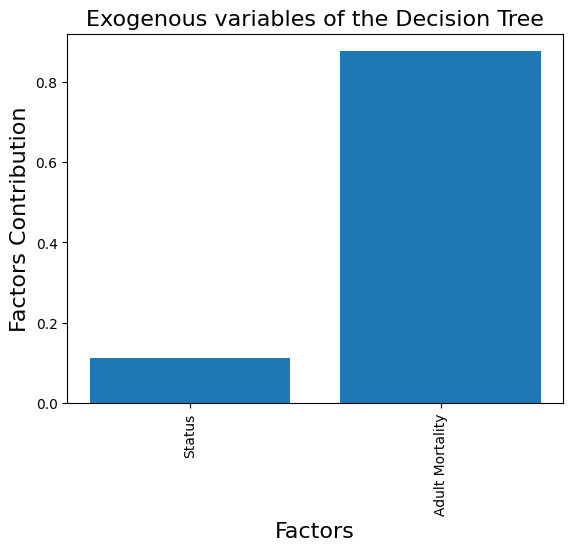

In [ ]:
# Building the best model
dt= tree.DecisionTreeRegressor(**params_dt).fit(X_train, Y_train)
predictions = dt.predict(X_test)
results_dt = pd.DataFrame()
results_dt['predictions'] = predictions

#  Display parameters that affect the target variable by more than 0.01
plt.bar(X_train.columns[dt.feature_importances_ > 0.01], dt.feature_importances_[dt.feature_importances_ > 0.01 ])
plt.title('Exogenous variables of the Decision Tree', fontsize=16)
plt.xlabel('Factors', fontsize=16)
plt.ylabel('Factors Contribution', fontsize=16)
plt.xticks(rotation = 90)

calculating_model_param(X_train, Y_train, X_test, Y_test, results_dt['predictions'], dt, results_table, 'Decision Tree', 'factor_odf')

In [ ]:
# Checking the Accuracy of a Random Forest Model

def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 500)
    max_depth = trial.suggest_int('max_depth', 2, 100)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 100)
    min_impurity_decrease = trial.suggest_float('min_impurity_decrease', 0, 0.1, step=0.0001)
    ccp_alpha = trial.suggest_float('ccp_alpha', 0.0, 0.1, step=0.0001)

    rf = sklearn.ensemble.RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth = max_depth,
        min_samples_leaf = min_samples_leaf,
        min_impurity_decrease = min_impurity_decrease,
        ccp_alpha = ccp_alpha,
        random_state=0
    )
    rf.fit(X_train, Y_train)

    return rf.score(X_test, Y_test)


study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=100, n_jobs=-1)
params_rf = study_rf.best_params

[I 2023-06-26 18:58:39,222] A new study created in memory with name: no-name-95f29467-aa8a-4f52-92b5-5d1d37c9ed78
[I 2023-06-26 18:58:39,566] Trial 0 finished with value: 0.8700614151973347 and parameters: {'n_estimators': 20, 'max_depth': 73, 'min_samples_leaf': 20, 'min_impurity_decrease': 0.0606, 'ccp_alpha': 0.07200000000000001}. Best is trial 0 with value: 0.8700614151973347.
[I 2023-06-26 18:58:41,107] Trial 2 finished with value: 0.8571601818206701 and parameters: {'n_estimators': 192, 'max_depth': 66, 'min_samples_leaf': 47, 'min_impurity_decrease': 0.0284, 'ccp_alpha': 0.0376}. Best is trial 0 with value: 0.8700614151973347.
[I 2023-06-26 18:58:42,328] Trial 1 finished with value: 0.8325978042266402 and parameters: {'n_estimators': 420, 'max_depth': 73, 'min_samples_leaf': 80, 'min_impurity_decrease': 0.0472, 'ccp_alpha': 0.0792}. Best is trial 0 with value: 0.8700614151973347.
[I 2023-06-26 18:58:43,588] Trial 3 finished with value: 0.8563675018105679 and parameters: {'n_esti

Test R^2 Train R^2  Mean Absolute Error  \
Frame       Methods                                                      
factor_odf  Linear Regression  0.594753         -             4.251240   
            Decision Tree      0.879474  0.882365             2.262112   
            Random Forest      0.887784  0.907623             2.255371   
            Gradient Boosting       NaN       NaN                  NaN   
country_odf Linear Regression       NaN       NaN                  NaN   
            Decision Tree           NaN       NaN                  NaN   
            Random Forest           NaN       NaN                  NaN   
            Gradient Boosting       NaN       NaN                  NaN   
odf         Linear Regression       NaN       NaN                  NaN   
            Decision Tree           NaN       NaN                  NaN   
            Random Forest           NaN       NaN                  NaN   
            Gradient Boosting       NaN       NaN                  NaN   

                               Trivial Mean Absolute Error  \
Frame       Methods                                          
factor_odf  Linear Regression                     7.606322   
            Decision Tree                         7.606322   
            Random Forest                         7.606322   
            Gradient Boosting                          NaN   
country_odf Linear Regression                          NaN   
            Decision Tree                              NaN   
            Random Forest                              NaN   
            Gradient Boosting                          NaN   
odf         Linear Regression                          NaN   
            Decision Tree                              NaN   
            Random Forest                              NaN   
            Gradient Boosting                          NaN   

                               Mean Squared Error  Trivial Mean Squared Error  \
Frame       Methods                                                             
factor_odf  Linear Regression           35.292286                   87.831367   
            Decision Tree               10.585980                   87.831367   
            Random Forest                9.856085                   87.831367   
            Gradient Boosting                 NaN                         NaN   
country_odf Linear Regression                 NaN                         NaN   
            Decision Tree                     NaN                         NaN   
            Random Forest                     NaN                         NaN   
            Gradient Boosting                 NaN                         NaN   
odf         Linear Regression                 NaN                         NaN   
            Decision Tree                     NaN                         NaN   
            Random Forest                     NaN                         NaN   
            Gradient Boosting                 NaN                         NaN   

                               The Model Is Beter On [%] By MAE  \
Frame       Methods                                               
factor_odf  Linear Regression                         44.109118   
            Decision Tree                             70.260107   
            Random Forest                             70.348730   
            Gradient Boosting                               NaN   
country_odf Linear Regression                               NaN   
            Decision Tree                                   NaN   
            Random Forest                                   NaN   
            Gradient Boosting                               NaN   
odf         Linear Regression                               NaN   
            Decision Tree                                   NaN   
            Random Forest                                   NaN   
            Gradient Boosting                               NaN   

                               The Model Is Beter O

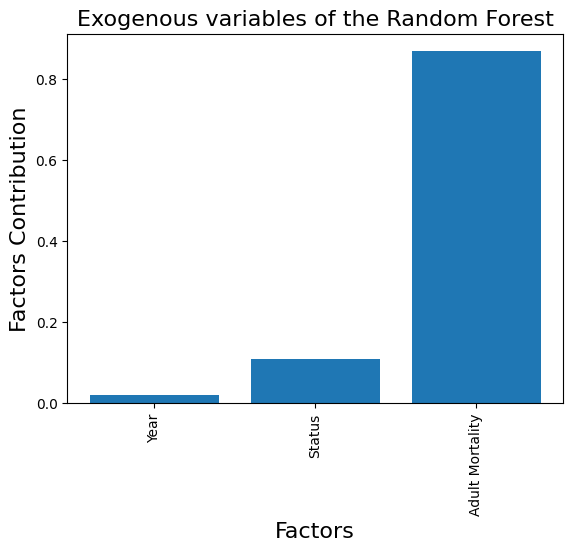

In [ ]:
rf = sklearn.ensemble.RandomForestRegressor(**params_rf, random_state=0).fit(X_train, Y_train)
predictions_rf = rf.predict(X_test)
results_rf = pd.DataFrame()
results_rf['predictions'] = predictions_rf

plt.bar(X_train.columns[rf.feature_importances_ > 0.01], rf.feature_importances_[rf.feature_importances_ > 0.01 ])
plt.title('Exogenous variables of the Random Forest', fontsize=16)
plt.xlabel('Factors', fontsize=16)
plt.ylabel('Factors Contribution', fontsize=16)
plt.xticks(rotation = 90)

calculating_model_param(X_train, Y_train, X_test, Y_test, results_rf['predictions'], rf, results_table, 'Random Forest', 'factor_odf')

In [ ]:
# Checking Accuracy of a Gradient Boosted Model
def objective_gb(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.0, 0.4, step=0.0001)
    subsample = trial.suggest_float('subsample', 0.0001, 1.0, step=0.0001)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 10)
    n_estimators = trial.suggest_int('n_estimators', 1, 400)
    max_depth = trial.suggest_int('max_depth', 2, 100)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 100)
    min_impurity_decrease = trial.suggest_float('min_impurity_decrease', 0, 0.1, step=0.0001)
    ccp_alpha = trial.suggest_float('ccp_alpha', 0.0, 0.1, step=0.0001)

    gb = sklearn.ensemble.GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth = max_depth,
        min_samples_leaf = min_samples_leaf,
        min_impurity_decrease = min_impurity_decrease,
        ccp_alpha = ccp_alpha,
        max_leaf_nodes = max_leaf_nodes,
        min_samples_split = min_samples_split,
        subsample = subsample,
        learning_rate = learning_rate,
        random_state=0
    )
    gb.fit(X_train, Y_train)

    return gb.score(X_test, Y_test)


study_gb = optuna.create_study(direction="maximize")
study_gb.optimize(objective_gb, n_trials=100, n_jobs=-1)
params_gb = study_gb.best_params

[I 2023-06-26 19:02:46,417] A new study created in memory with name: no-name-f3961896-30bc-4720-b10d-4bc7d822a88c
[I 2023-06-26 19:02:46,690] Trial 0 finished with value: 0.8435776874122707 and parameters: {'learning_rate': 0.10590000000000001, 'subsample': 0.1736, 'min_samples_split': 4, 'max_leaf_nodes': 5, 'n_estimators': 116, 'max_depth': 2, 'min_samples_leaf': 29, 'min_impurity_decrease': 0.0438, 'ccp_alpha': 0.051800000000000006}. Best is trial 0 with value: 0.8435776874122707.
[I 2023-06-26 19:02:47,146] Trial 2 finished with value: 0.8713848283533877 and parameters: {'learning_rate': 0.2636, 'subsample': 0.743, 'min_samples_split': 5, 'max_leaf_nodes': 6, 'n_estimators': 89, 'max_depth': 72, 'min_samples_leaf': 19, 'min_impurity_decrease': 0.09630000000000001, 'ccp_alpha': 0.0475}. Best is trial 2 with value: 0.8713848283533877.
[I 2023-06-26 19:02:47,515] Trial 1 finished with value: 0.8258096086887157 and parameters: {'learning_rate': 0.1398, 'subsample': 0.3704, 'min_samples

Test R^2 Train R^2  Mean Absolute Error  \
Frame       Methods                                                      
factor_odf  Linear Regression  0.594753         -             4.251240   
            Decision Tree      0.879474  0.882365             2.262112   
            Random Forest      0.887784  0.907623             2.255371   
            Gradient Boosting  0.891805  0.912488             2.213044   
country_odf Linear Regression       NaN       NaN                  NaN   
            Decision Tree           NaN       NaN                  NaN   
            Random Forest           NaN       NaN                  NaN   
            Gradient Boosting       NaN       NaN                  NaN   
odf         Linear Regression       NaN       NaN                  NaN   
            Decision Tree           NaN       NaN                  NaN   
            Random Forest           NaN       NaN                  NaN   
            Gradient Boosting       NaN       NaN                  NaN   

                               Trivial Mean Absolute Error  \
Frame       Methods                                          
factor_odf  Linear Regression                     7.606322   
            Decision Tree                         7.606322   
            Random Forest                         7.606322   
            Gradient Boosting                     7.606322   
country_odf Linear Regression                          NaN   
            Decision Tree                              NaN   
            Random Forest                              NaN   
            Gradient Boosting                          NaN   
odf         Linear Regression                          NaN   
            Decision Tree                              NaN   
            Random Forest                              NaN   
            Gradient Boosting                          NaN   

                               Mean Squared Error  Trivial Mean Squared Error  \
Frame       Methods                                                             
factor_odf  Linear Regression           35.292286                   87.831367   
            Decision Tree               10.585980                   87.831367   
            Random Forest                9.856085                   87.831367   
            Gradient Boosting            9.502912                   87.831367   
country_odf Linear Regression                 NaN                         NaN   
            Decision Tree                     NaN                         NaN   
            Random Forest                     NaN                         NaN   
            Gradient Boosting                 NaN                         NaN   
odf         Linear Regression                 NaN                         NaN   
            Decision Tree                     NaN                         NaN   
            Random Forest                     NaN                         NaN   
            Gradient Boosting                 NaN                         NaN   

                               The Model Is Beter On [%] By MAE  \
Frame       Methods                                               
factor_odf  Linear Regression                         44.109118   
            Decision Tree                             70.260107   
            Random Forest                             70.348730   
            Gradient Boosting                         70.905194   
country_odf Linear Regression                               NaN   
            Decision Tree                                   NaN   
            Random Forest                                   NaN   
            Gradient Boosting                               NaN   
odf         Linear Regression                               NaN   
            Decision Tree                                   NaN   
            Random Forest                                   NaN   
            Gradient Boosting                               NaN   

                               The Model Is Beter O

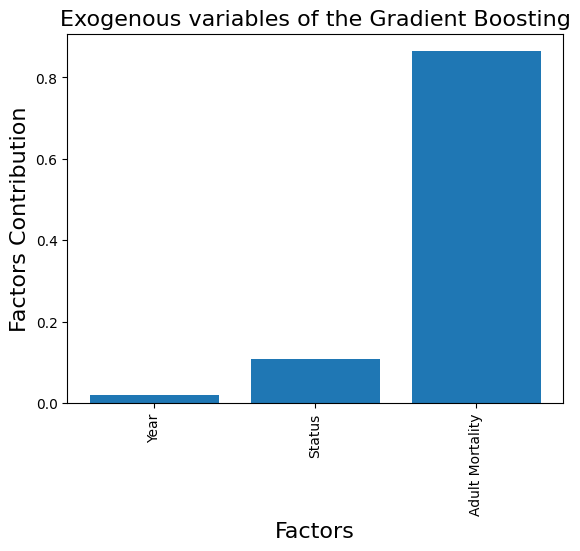

In [ ]:
gb = sklearn.ensemble.GradientBoostingRegressor(**params_gb, random_state=0).fit(X_train, Y_train)
predictions_gb = gb.predict(X_test)
results_gb = pd.DataFrame()
results_gb['predictions'] = predictions_gb
plt.bar(X_train.columns[gb.feature_importances_ > 0.01], gb.feature_importances_[gb.feature_importances_ > 0.01 ])
plt.title('Exogenous variables of the Gradient Boosting', fontsize=16)
plt.xlabel('Factors', fontsize=16)
plt.ylabel('Factors Contribution', fontsize=16)
plt.xticks(rotation = 90)

calculating_model_param(X_train, Y_train, X_test, Y_test, results_gb['predictions'], gb, results_table, 'Gradient Boosting', 'factor_odf')

In [ ]:
country_odf.isna().mean() * 100

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.000000
Adult Mortality                     0.000000
infant deaths                       0.000000
Alcohol                             6.250000
percentage expenditure              0.000000
Hepatitis B                        26.988636
Measles                            34.659091
 BMI                                0.000000
under-five deaths                   0.000000
Polio                               0.000000
Total expenditure                   6.250000
Diphtheria                          0.000000
 HIV/AIDS                           0.000000
GDP                                 0.000000
Population                          0.000000
 thinness  1-19 years               0.000000
 thinness 5-9 years                 0.000000
Income composition of resources     0.000000
Schooling                           0.000000
infant dea